In [18]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation, LSTM
from keras import backend as K
from keras.regularizers import l2
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
ref_data = pd.read_csv('data/artificialNoAnomaly/art_daily_small_noise.csv')
new_data = pd.read_csv('data/artificialWithAnomaly/art_daily_jumpsup.csv')

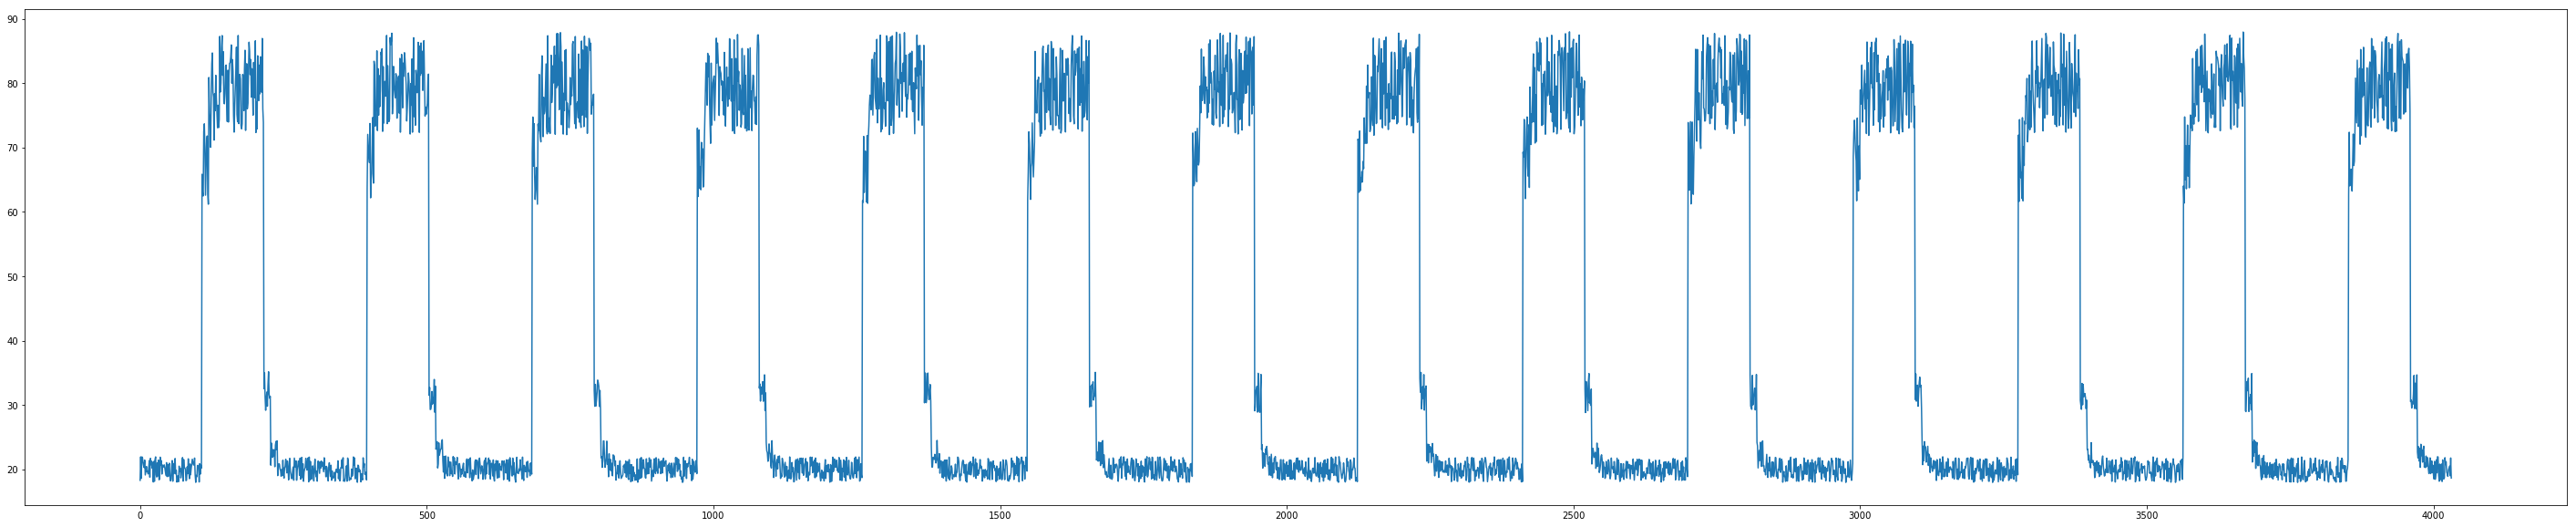

In [123]:
plt.figure(figsize=(50,10))
plt.plot(ref_data['value'])

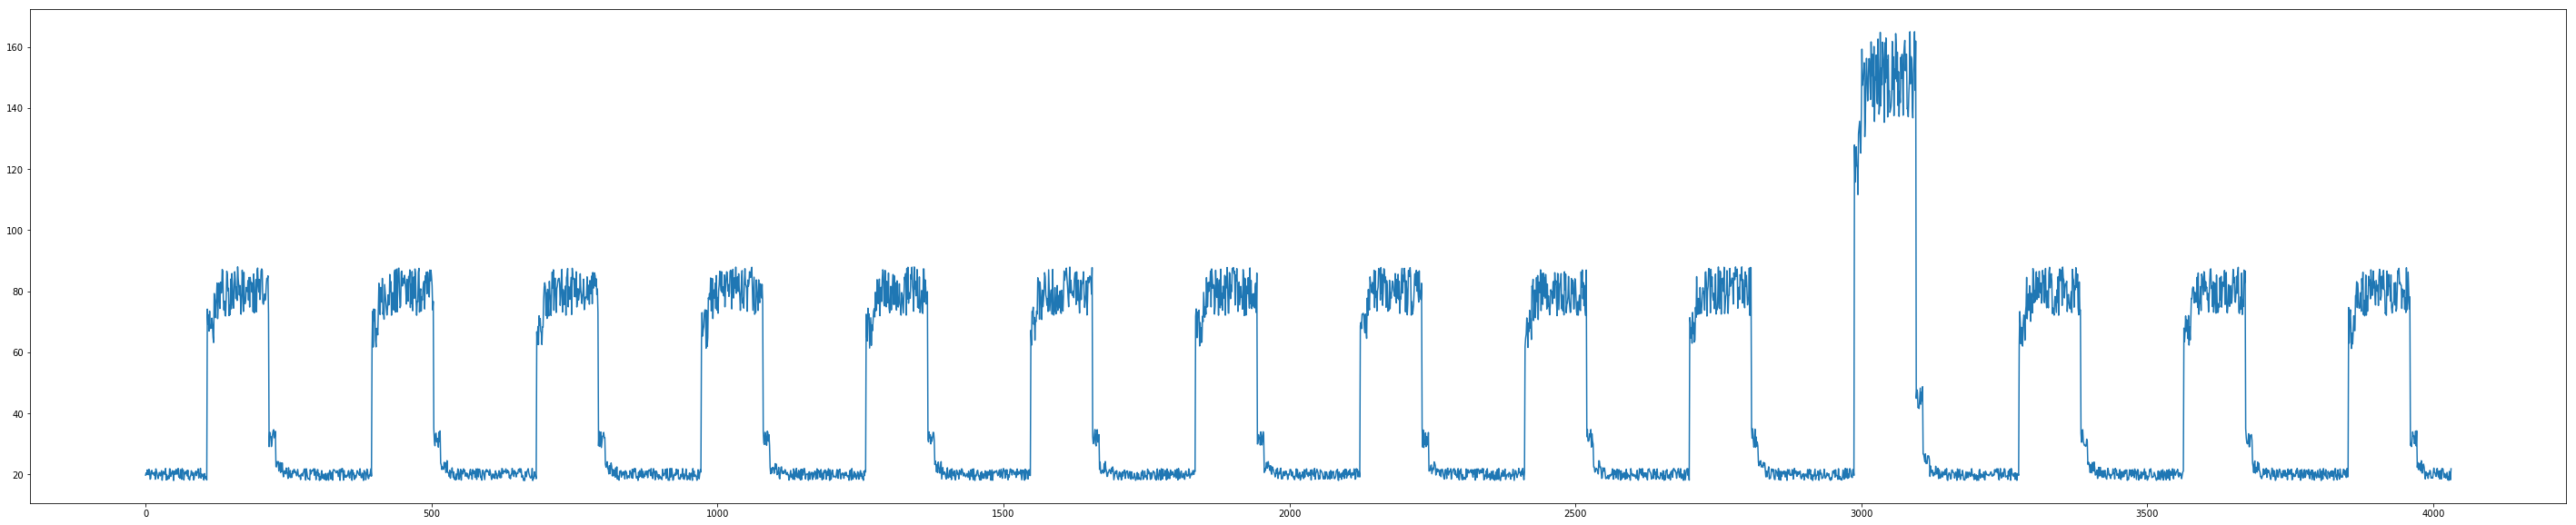

In [124]:
plt.figure(figsize=(50,10))
plt.plot(new_data['value'])

In [125]:
ref_data = ref_data['value'].as_matrix()
new_data = new_data['value'].as_matrix()


In [126]:
new_data = ref_data + 1*np.random.randn(1,len(ref_data)).flatten()

In [127]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

X,Y = create_dataset(ref_data,look_back=500)
Xnew,Ynew = create_dataset(new_data, look_back=500)

In [128]:
X_train = X[:3000]
X_val = X[3000:]
y_train = Y[:3000]
y_val = Y[3000:]

In [129]:
model = Sequential()
model.add(Dropout(0.05, input_shape=(X_train.shape[1],)))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001)))
model.add(Dropout(0.05))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001)))
model.add(Dropout(0.05))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001)))
model.add(Dropout(0.05))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001)))
model.add(Dropout(0.05))
model.add(Dense(1))
model.compile(optimizer='adam',
              loss='mse')

In [130]:
model.fit(X_train, y_train,
          batch_size=100, epochs=100,
          validation_data=(X_val, y_val),
         verbose=1)

Train on 3000 samples, validate on 531 samples
Epoch 1/100
3000/3000 [==============================] - 0s - loss: 274.5941 - val_loss: 40.9042
Epoch 2/100
3000/3000 [==============================] - 0s - loss: 94.0310 - val_loss: 38.4244
Epoch 3/100
3000/3000 [==============================] - 0s - loss: 71.6954 - val_loss: 46.1366
Epoch 4/100
3000/3000 [==============================] - 0s - loss: 66.2809 - val_loss: 104.9103
Epoch 5/100
3000/3000 [==============================] - 0s - loss: 62.3183 - val_loss: 51.5297
Epoch 6/100
3000/3000 [==============================] - 0s - loss: 50.9603 - val_loss: 72.3306
Epoch 7/100
3000/3000 [==============================] - 0s - loss: 48.8881 - val_loss: 24.6203
Epoch 8/100
3000/3000 [==============================] - 0s - loss: 47.8451 - val_loss: 60.4764
Epoch 9/100
3000/3000 [==============================] - 0s - loss: 47.9123 - val_loss: 41.9638
Epoch 10/100
3000/3000 [==============================] - 0s - loss: 41.7809 - val_loss

3000/3000 [==============================] - 0s - loss: 19.5918 - val_loss: 66.9421
Epoch 85/100
3000/3000 [==============================] - 0s - loss: 21.9256 - val_loss: 58.2365
Epoch 86/100
3000/3000 [==============================] - 0s - loss: 18.0850 - val_loss: 56.6109
Epoch 87/100
3000/3000 [==============================] - 0s - loss: 20.3791 - val_loss: 54.5833
Epoch 88/100
3000/3000 [==============================] - 0s - loss: 20.1390 - val_loss: 62.4146
Epoch 89/100
3000/3000 [==============================] - 0s - loss: 18.8162 - val_loss: 114.6096
Epoch 90/100
3000/3000 [==============================] - 0s - loss: 22.0086 - val_loss: 41.2437
Epoch 91/100
3000/3000 [==============================] - 0s - loss: 23.8354 - val_loss: 53.3860
Epoch 92/100
3000/3000 [==============================] - 0s - loss: 23.4473 - val_loss: 82.3641
Epoch 93/100
3000/3000 [==============================] - 0s - loss: 18.8275 - val_loss: 68.3915
Epoch 94/100
3000/3000 [==================

In [131]:
yhat = model.predict(X_val)

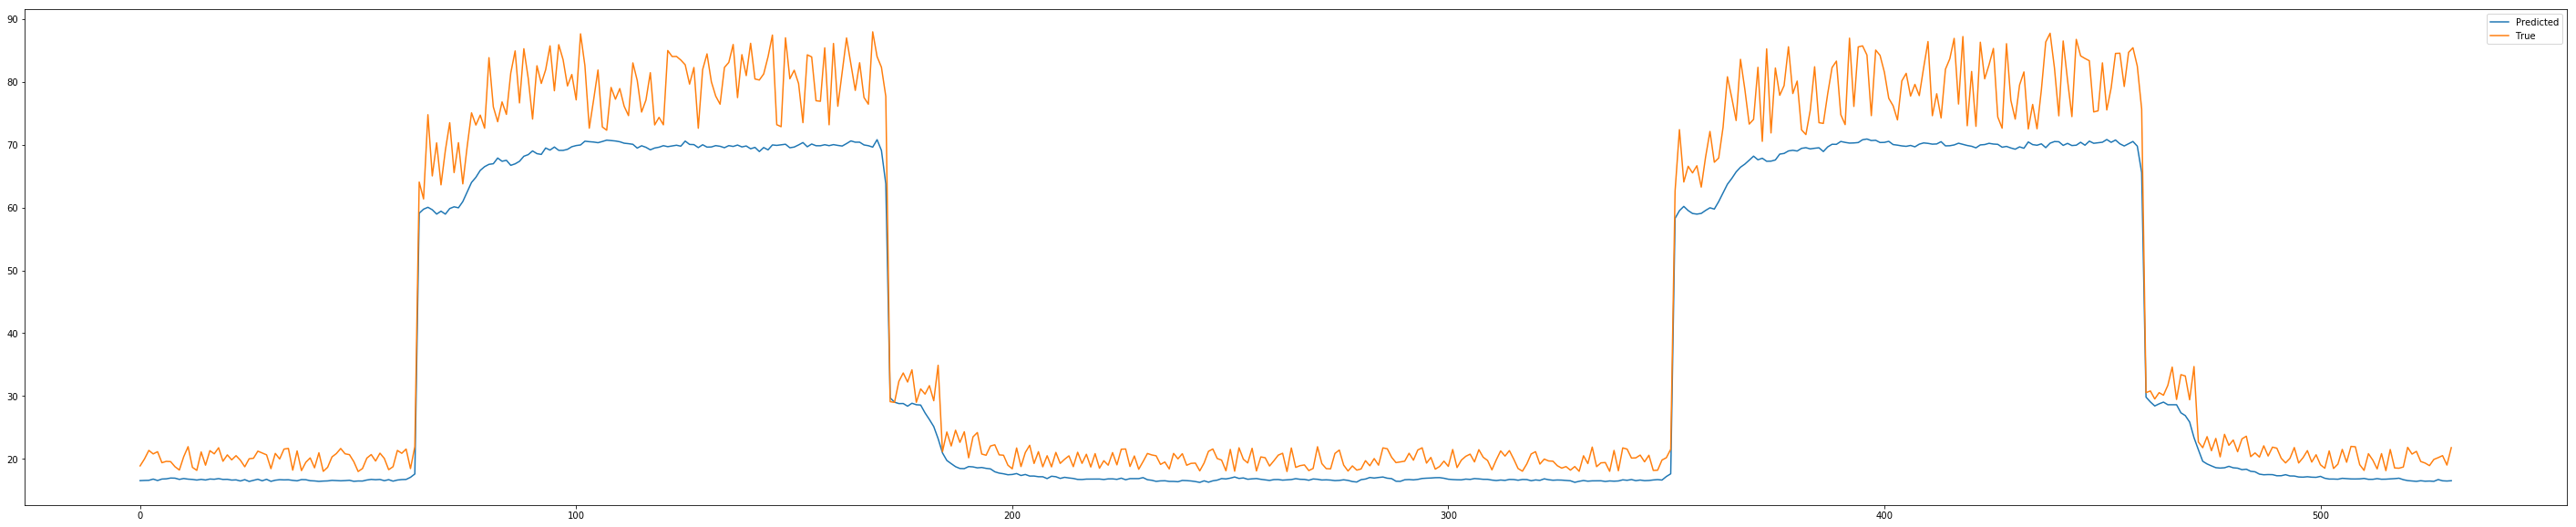

In [132]:
plt.figure(figsize=(50,10))
plt.plot(yhat,label='Predicted')
plt.plot(y_val, label='True')
plt.legend()

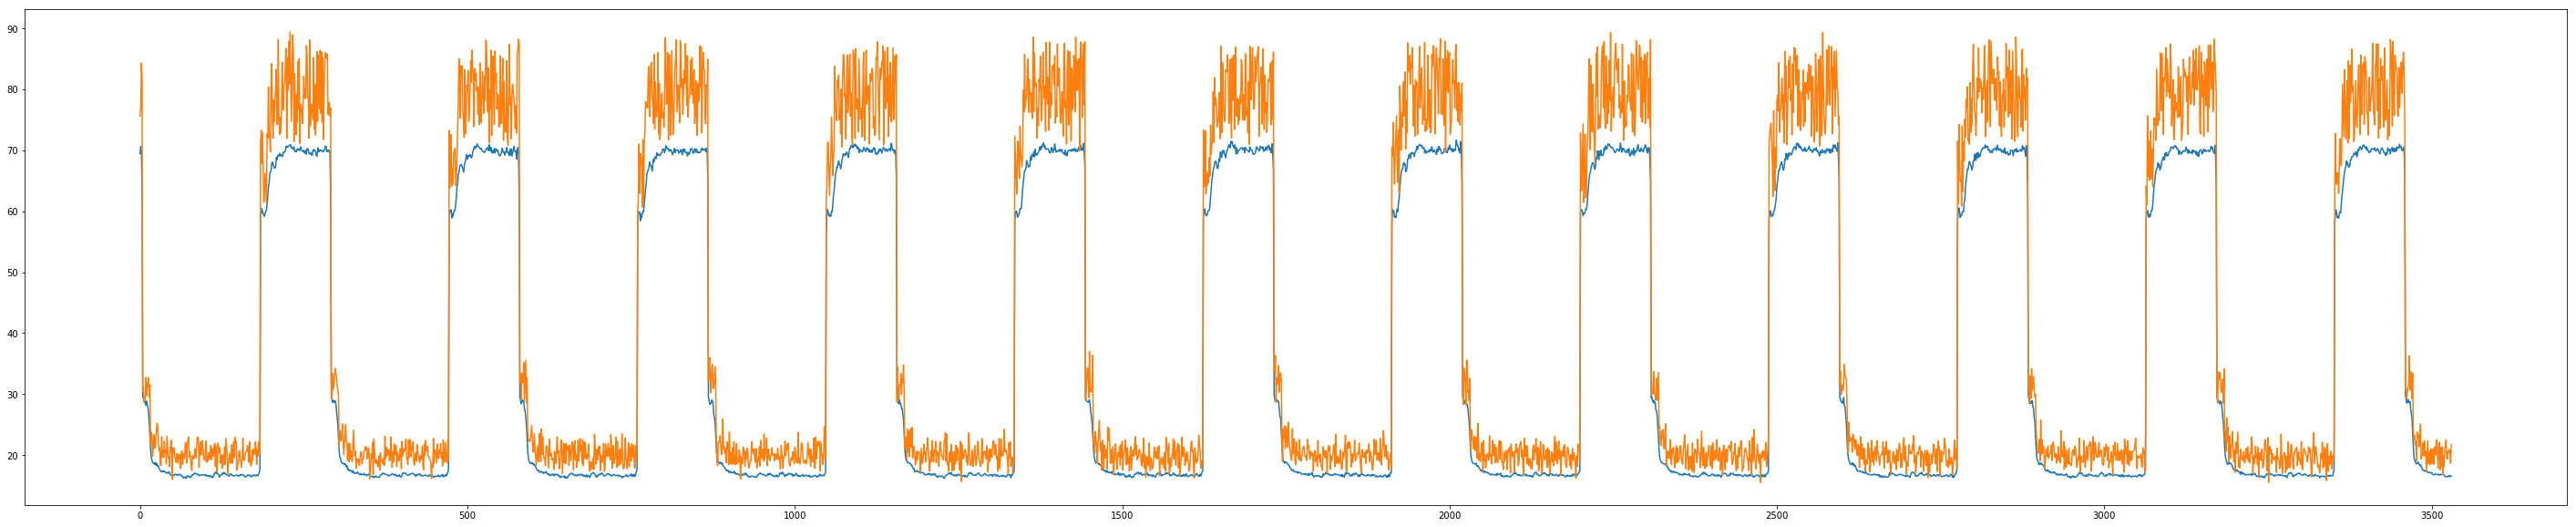

In [133]:
yhatnew = model.predict(Xnew)
plt.figure(figsize=(50,10))
plt.plot(yhatnew)
plt.plot(Ynew)

In [134]:
T = 100
predict_stochastic = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
Yt_hat = np.array([predict_stochastic([Xnew, 1]) for _ in range(T)])
#Yt_hat = Yt_hat * np.std(y_train) + np.mean(y_train)
MC_pred = np.mean(Yt_hat, 0)

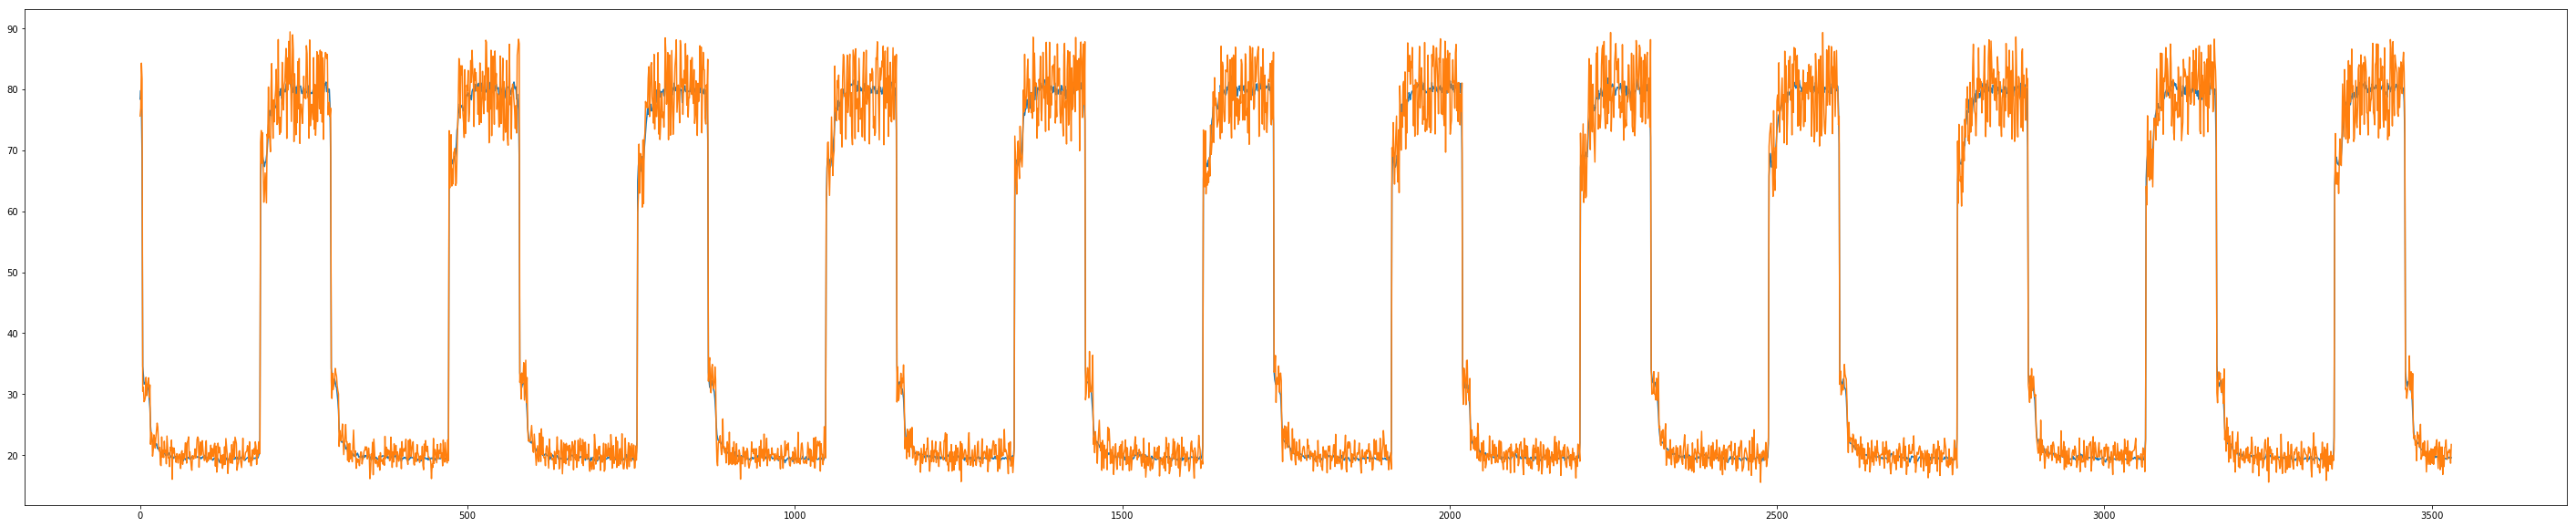

In [135]:
plt.figure(figsize=(50,10))
plt.plot(MC_pred.flatten())
plt.plot(Ynew)

In [136]:
test= Yt_hat[:,0,:,0]
teststd = np.std(test,axis=0)

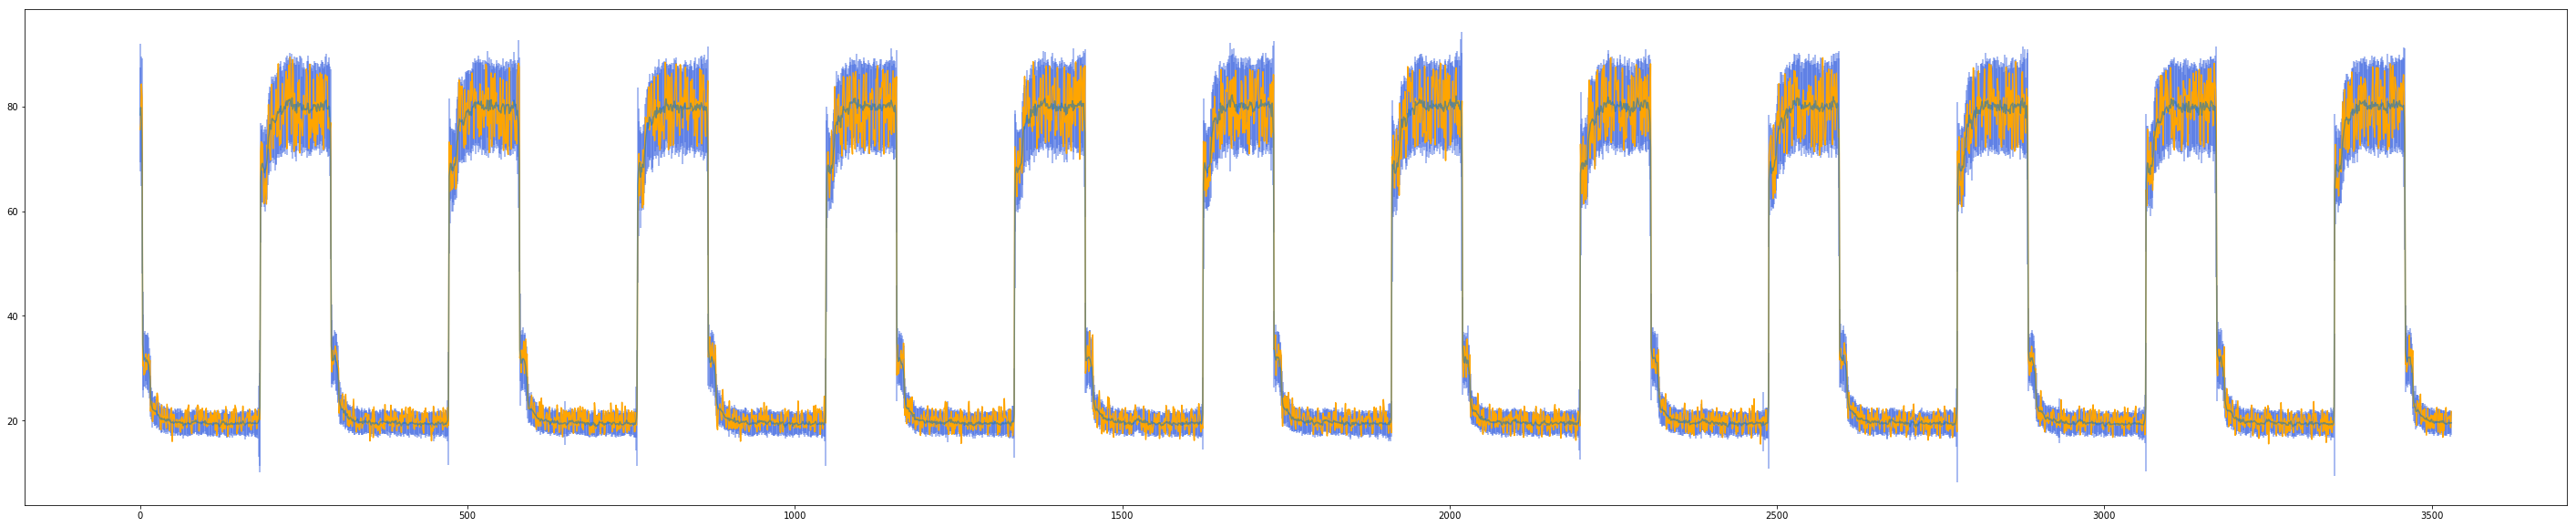

In [137]:
plt.figure(figsize=(50,10))
plt.errorbar(range(len(Xnew)),MC_pred.flatten(),2*teststd,ecolor='royalblue',alpha=0.6)
plt.plot(Ynew,color='orange',alpha=1)